# Tryouts with pix2pix NNs

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [4]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [17]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, ORDERED_LABEL_IDS, TRAIN_DATA, TRAIN_LABEL_TILES
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels

## Data generator

In [9]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files if 'mean' not in s and 'std' not in s])
print "First train tile : ", all_train_files[0], all_train_files[-1], len(all_train_files)

First train tile :  6010_1_2 6170_4_1 25


In [10]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]


mean_fname = os.path.join(TRAIN_DATA, 'mean_image.tif')
std_fname = os.path.join(TRAIN_DATA, 'std_image.tif')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files, 'input')
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

No handlers could be found for logger "geo_utils.GeoImage"


(3349L, 3404L, 17L) (3349L, 3404L, 17L)
-21597.8 1900.22 0.0 94449.1
20 5


In [58]:
from data_utils import get_image_ids
from training_utils import tile_iterator

def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out

def generate_images(image_ids_to_use, batch_size):
    while True:        
        X = np.zeros((batch_size, n_channels)+tile_size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size[::-1], dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use, labels,
                              image_type='input', label_type='label_1d',
                              balance_classes=False,
                              presence_percentage=2, 
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image
                             )
        counter = 0
        for x, y in tiles:     

            if len(channels) < 17:
                x = x[:,:,channels]
            
            x = normalize_image(x)
            y = y.transpose([2,0,1])   

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


Input image bands:

```
Pan, NDVI, GEMI, NDWI2, NDTI, BI, BI2, -BI, -BI2, Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
 0     1     2     3      4    5   6     7    8      9      10     11     12     13     14        15        16
```


In [59]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'input', return_shape_only=True)

tile_size = (256, 256)
# Select red, green, 
channels = np.array([13, 11, 10])
n_channels = len(channels)

labels = ORDERED_LABEL_IDS[1:]
#labels = np.array([5, 6])
n_labels = 1

In [60]:
channels, labels, np.array(LABELS)[labels]

(array([13, 11, 10]),
 [6, 4, 3, 8, 7, 2, 10, 9, 1, 5],
 array(['Crops', 'Track', 'Road', 'Standing water', 'Waterway',
        'Misc. Manmade structures', 'Vehicle Small', 'Vehicle Large',
        'Buildings', 'Trees'], 
       dtype='|S24'))

(5L, 3L, 256L, 256L) (5L, 1L, 256L, 256L)
-2.14756 4.29419 0.0 10.0


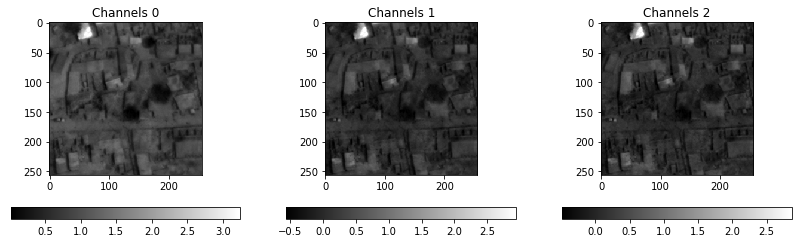

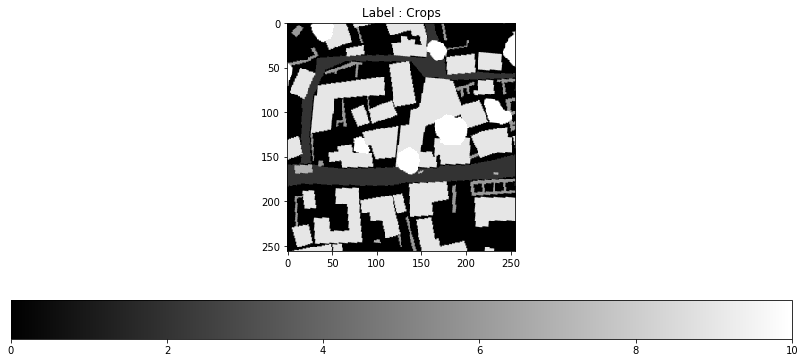

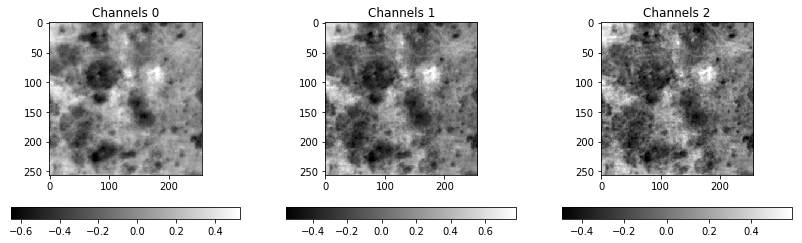

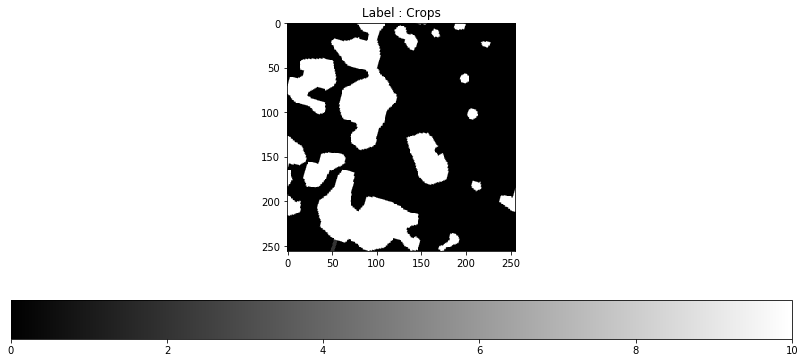

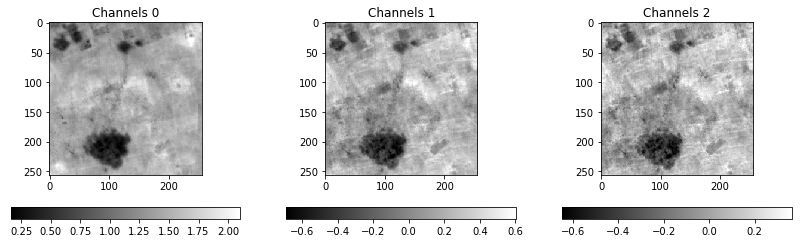

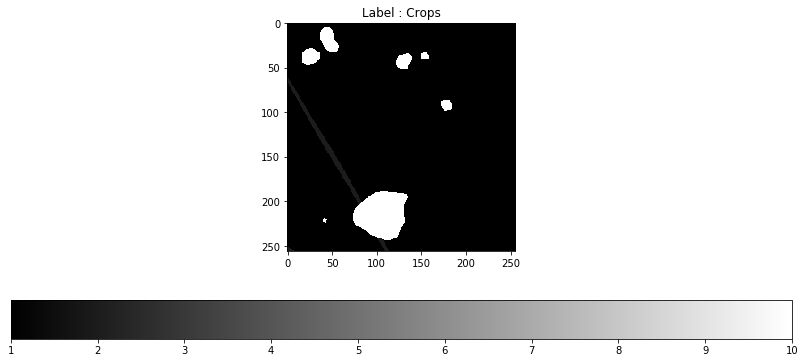

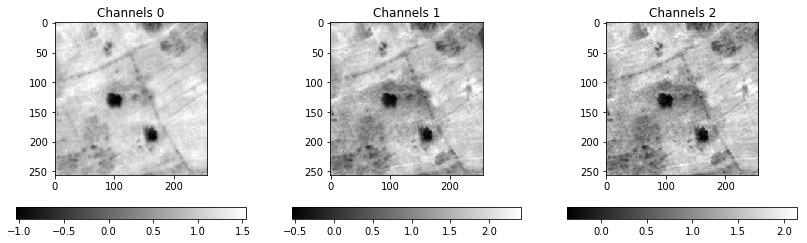

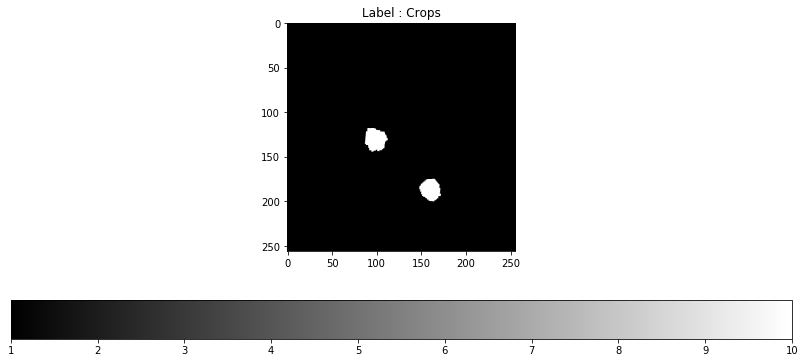

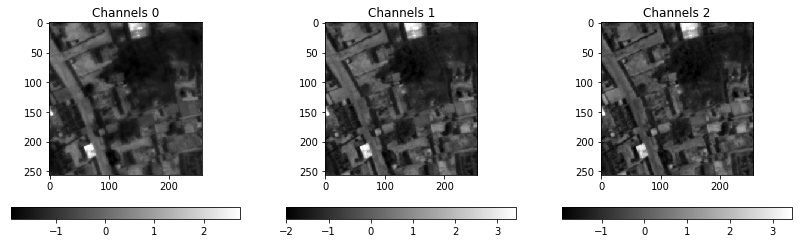

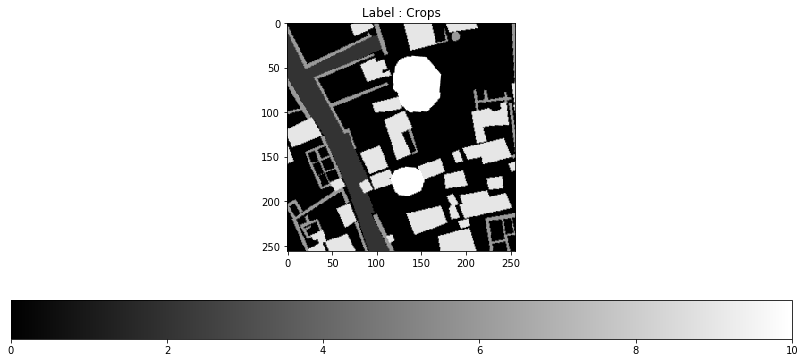

In [61]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        m = 3
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

## Load generator and discriminator

In [7]:
import pix2pix_models as models

In [102]:
patch_size = (70, 70) # can be 16, 16 and specifies patch size for PatchGAN
generator = "upsampling"
in_img_dim = (n_channels, tile_size[1], tile_size[0])
out_img_dim = (1, tile_size[1], tile_size[0])

nb_patch = (img_dim[1] / patch_size[0]) * (img_dim[2] / patch_size[1])
img_dim_disc = (out_img_dim[0], patch_size[0], patch_size[1])

bn_mode = 2 # Feature-wise batch normalization
use_mbd = False
batch_size = 4

print nb_patch, img_dim_disc

9 (1, 70, 70)


In [103]:
# Load generator model
generator_model = models.load("generator_unet_%s" % generator,
                              in_img_dim, out_img_dim,
                              None,
                              bn_mode,
                              use_mbd,
                              batch_size)
# Load discriminator model
discriminator_model = models.load("DCGAN_discriminator",
                                  None, img_dim_disc,
                                  nb_patch,
                                  bn_mode,
                                  use_mbd,
                                  batch_size)


-- Generator U-Net with upsampling
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
unet_input (InputLayer)          (None, 3, 256, 256)   0                                            
____________________________________________________________________________________________________
unet_conv2D_1 (Convolution2D)    (None, 64, 128, 128)  1792        unet_input[0][0]                 
____________________________________________________________________________________________________
leakyrelu_139 (LeakyReLU)        (None, 64, 128, 128)  0           unet_conv2D_1[0][0]              
____________________________________________________________________________________________________
unet_conv2D_2 (Convolution2D)    (None, 128, 64, 64)   73856       leakyrelu_139[0][0]              
_______________________________________________________

In [104]:
from keras.optimizers import Adam

opt_dcgan = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt_discriminator = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

generator_model.compile(loss='mae', optimizer=opt_discriminator)
discriminator_model.trainable = False

In [106]:
DCGAN_model = models.DCGAN(generator_model, discriminator_model, in_img_dim, out_img_dim, patch_size)

def l1_loss(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true), axis=-1)

loss = [l1_loss, 'binary_crossentropy']
loss_weights = [1E1, 1]
DCGAN_model.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)

discriminator_model.trainable = True
discriminator_model.compile(loss='binary_crossentropy', optimizer=opt_discriminator)


In [108]:
nb_epoch = 10 # 400
label_smoothing = True
label_flipping = 0.5

In [113]:
import time
from pix2pix_training_utils import compute_disc_batch

gen_loss = 100
disc_loss = 100

try:
    # Start training
    print("Start training")
    for e in range(nb_epoch):
        # Initialize progbar and batch counter
        batch_counter = 1
        start = time.time()

        for X_in, X_out in generate_images(train_files, batch_size):
        #for X_full_batch, X_sketch_batch in data_utils.gen_batch(X_full_train, X_sketch_train, batch_size):

            # Create a batch to feed the discriminator model
            X_disc, y_disc = compute_disc_batch(X_in,
                                                X_out,
                                                generator_model,
                                                batch_counter,
                                                patch_size,
                                                label_smoothing=label_smoothing,
                                                label_flipping=label_flipping)

            # Update the discriminator
            disc_loss = discriminator_model.train_on_batch(X_disc, y_disc)

            # Create a batch to feed the generator model
            X_gen_target, X_gen = next(data_utils.gen_batch(X_full_train, X_sketch_train, batch_size))
            y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
            y_gen[:, 1] = 1

            # Freeze the discriminator
            discriminator_model.trainable = False
            gen_loss = DCGAN_model.train_on_batch(X_gen, [X_gen_target, y_gen])
            # Unfreeze the discriminator
            discriminator_model.trainable = True

            batch_counter += 1
            progbar.add(batch_size, values=[("D logloss", disc_loss),
                                            ("G tot", gen_loss[0]),
                                            ("G L1", gen_loss[1]),
                                            ("G logloss", gen_loss[2])])

            # Save images for visualization
            if batch_counter % (n_batch_per_epoch / 2) == 0:
                # Get new images from validation
                data_utils.plot_generated_batch(X_full_batch, X_sketch_batch, generator_model,
                                                batch_size, image_dim_ordering, "training")
                X_full_batch, X_sketch_batch = next(data_utils.gen_batch(X_full_val, X_sketch_val, batch_size))
                data_utils.plot_generated_batch(X_full_batch, X_sketch_batch, generator_model,
                                                batch_size, image_dim_ordering, "validation")

            if batch_counter >= n_batch_per_epoch:
                break

        print("")
        print('Epoch %s/%s, Time: %s' % (e + 1, nb_epoch, time.time() - start))

        if e % 5 == 0:
            gen_weights_path = os.path.join('../../models/%s/gen_weights_epoch%s.h5' % (model_name, e))
            generator_model.save_weights(gen_weights_path, overwrite=True)

            disc_weights_path = os.path.join('../../models/%s/disc_weights_epoch%s.h5' % (model_name, e))
            discriminator_model.save_weights(disc_weights_path, overwrite=True)

            DCGAN_weights_path = os.path.join('../../models/%s/DCGAN_weights_epoch%s.h5' % (model_name, e))
            DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)

except KeyboardInterrupt:
    pass


Start training


ValueError: Error when checking model input: you are passing a list as input to your model, but the model expects a list of 9 Numpy arrays instead. The list you passed was: []